### https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775

#### The exponential moving average is a widely used method to filter out noise and identify trends. The weight of each element decreases progressively over time, meaning the exponential moving average gives greater weight to recent data points. This is done under the idea that recent data is more relevant than old data. Compared to the simple moving average, the exponential moving average reacts faster to changes, since is more sensitive to recent movements.

#### α is the smoothing factor. The smoothing factor has a value between 0 and 1 and represents the weighting applied to the most recent period.

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
from tqdm.notebook import tqdm 

import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler
from sklearn.metrics import mean_absolute_error

In [3]:
df = pd.read_excel("Gold-Historical-Prices-1 (2).xlsx"
                  ,sheet_name="Gold Historical Data")

In [4]:
df = df[['Price', "Date"]]
df = df[df.Price.notna()]
df.sort_values("Date", inplace=True)
df.set_index("Date", inplace=True)
df_1980 = df[df.index.year == 1980]
df_1981 = df[df.index.year == 1981]

## Predict stocks for 1980 based on January

In [5]:
total_working_days = 0
for i in range(0,12):
    print("Month:", i+1,df_1980[df_1980.index.month == i+1].shape[0], "working days.")
    total_working_days =  total_working_days + df_1980[df_1980.index.month == i+1].shape[0]
print("Number of working days", total_working_days)

Month: 1 23 working days.
Month: 2 21 working days.
Month: 3 21 working days.
Month: 4 22 working days.
Month: 5 22 working days.
Month: 6 21 working days.
Month: 7 23 working days.
Month: 8 21 working days.
Month: 9 22 working days.
Month: 10 23 working days.
Month: 11 20 working days.
Month: 12 23 working days.
Number of working days 262


In [6]:
#Working days except first month 
days_to_create_index = total_working_days - df_1980[df_1980.index.month == 1].shape[0]
#Separate January of the Year
df_jan = df_1980[df_1980.index.month == 1]
df_other_months = df_1980[df_1980.index.month != 1]

In [7]:
alphas = [0.55,0.65,0.75,0.85,0.95]
mses = []
rmses = []
dfs = []
for a in tqdm(alphas):
    df_for_pred = pd.concat([df_jan, pd.DataFrame(index=df_other_months.index)])
    counter = 0
    while df_for_pred["Price"].isna().sum() >0:
        try:
            counter += 2
            df_for_pred[f"Predicted_Price_{a}"] = pd.DataFrame(df_for_pred[f"Price"].ewm(alpha=a,adjust=True, min_periods=1).mean())
            #df_for_pred[df_for_pred["Predicted_Price"].notna()]["Predicted_Price"][-len(df_other_months)+counter:]
            idx = df_for_pred[f"Predicted_Price_{a}"][-len(df_other_months):-len(df_other_months)+counter+2].index.values
            df_for_pred.loc[idx,'Price'] = df_for_pred[f"Predicted_Price_{a}"][-len(df_other_months):-len(df_other_months)+counter+2]
        except:
            pass
    mse = mean_absolute_error(df_other_months['Price'],
            df_for_pred[df_for_pred[f"Predicted_Price_{a}"].index.month != 1][f"Predicted_Price_{a}"])

    rmse = np.sqrt(mse)
    mses.append(mse)
    rmses.append(rmse)
    dfs.append(df_for_pred)

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
df_MSE = pd.DataFrame(mses, columns = ["MSE"], index=["Predicted_Price_0.55",
                                            "Predicted_Price_0.65",
                                            "Predicted_Price_0.75",
                                            "Predicted_Price_0.85",
                                            "Predicted_Price_0.95",])

In [9]:
df_RMSE = pd.DataFrame(rmses, columns = ["RMSE"], index=["Predicted_Price_0.55",
                                            "Predicted_Price_0.65",
                                            "Predicted_Price_0.75",
                                            "Predicted_Price_0.85",
                                            "Predicted_Price_0.95",])

In [10]:
df_metrics = df_MSE.merge( df_RMSE, left_on=df_MSE.index, right_on=df_RMSE.index)

In [11]:
df_metrics

,key_0,MSE,RMSE
0,Predicted_Price_0.55,63.892728,7.993293
1,Predicted_Price_0.65,62.722305,7.919741
2,Predicted_Price_0.75,61.470079,7.840286
3,Predicted_Price_0.85,59.945635,7.742457
4,Predicted_Price_0.95,58.125838,7.624030


In [12]:
## Best Predictions with alpha 0.95
dfs[4]['Predicted_Price_0.95']

Date
1980-01-01    512.000000
1980-01-02    557.476190
1980-01-03    630.420428
1980-01-04    634.058544
1980-01-07    634.002927
                 ...    
1980-12-25    654.852134
1980-12-26    654.852134
1980-12-29    654.852134
1980-12-30    654.852134
1980-12-31    654.852134
Name: Predicted_Price_0.95, Length: 262, dtype: float64

In [13]:
# df_for_pred = pd.concat([df_jan, pd.DataFrame(index=df_other_months.index)])
# df_for_pred[f"Predicted_Price"] = df_for_pred[f"Price"].ewm(span=3, min_periods=1).mean()

# df_jan[df_for_pred[f"Price"].notna()].index

# df_for_pred = pd.concat([df_jan, pd.DataFrame(index=df_other_months.index)])

# df_for_pred = pd.concat([df_jan, pd.DataFrame(index=df_other_months.index)])
# df_for_pred[f"Predicted_Price"] = pd.DataFrame(df_for_pred[f"Price"].ewm(span=23,
#                                                                          min_periods=1,
#                                                                          #ignore_na=True,
#                                                                          #halflife='23 days',
#                                                                          #times=df_for_pred.index
#                                                                         ).mean())

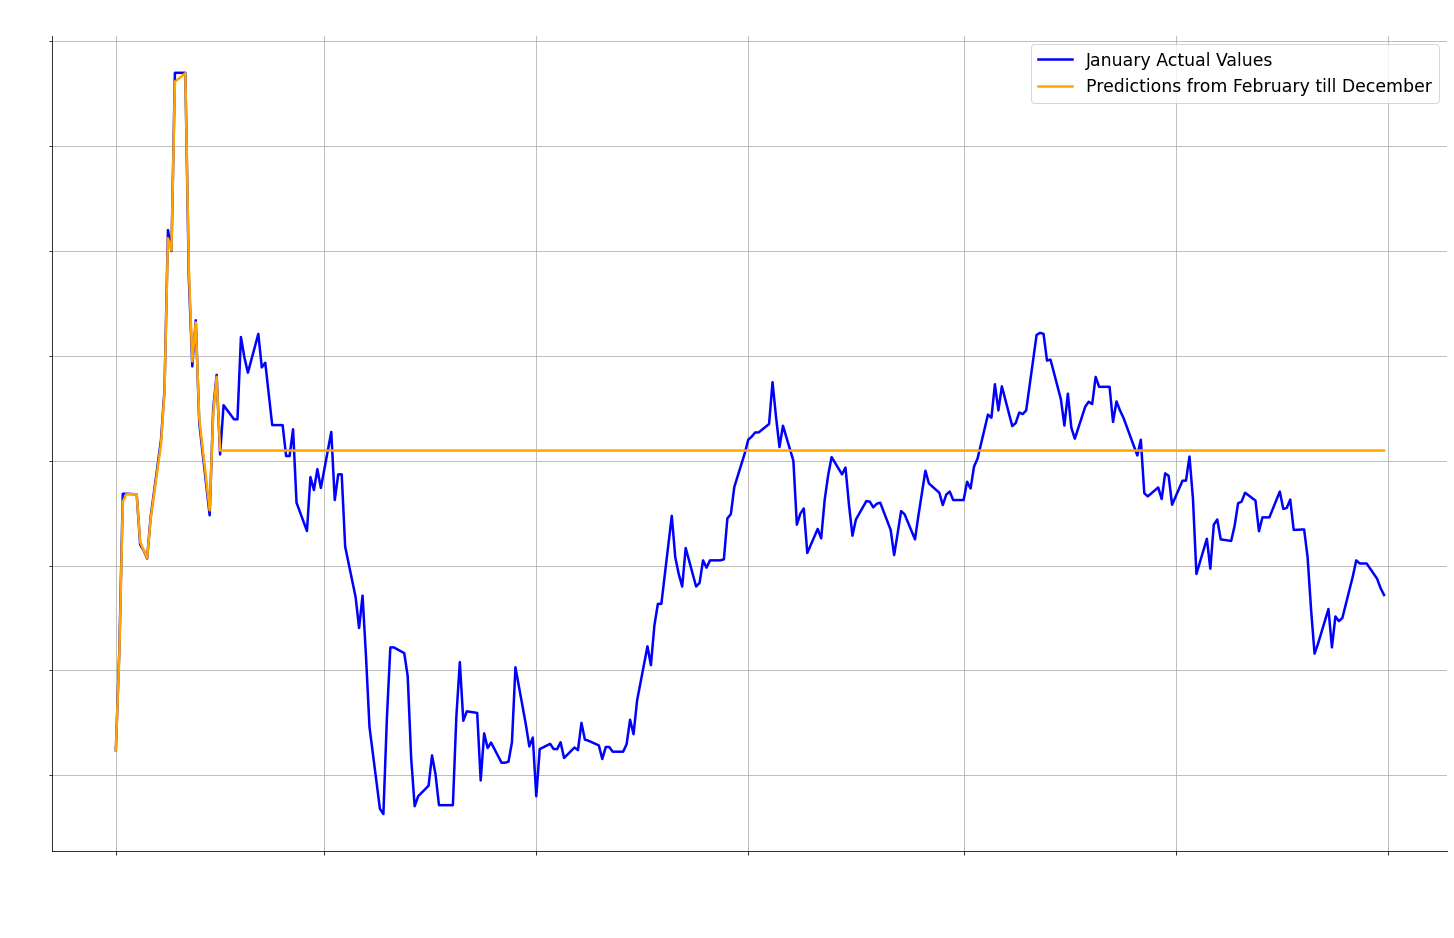

In [14]:
rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5

# Plot
plt.figure(figsize=(25,15))
plt.plot(df_1980["Price"], color = "blue",label='January Actual Values')
plt.plot(dfs[4]['Predicted_Price_0.95'], color = "orange",label='Predictions from February till December')

plt.title('Stocks dataset', size=30, color="w")
plt.grid()
plt.xticks(color="w", size=20, rotation=45)
plt.yticks(color="w", size=20)
plt.legend(fontsize='xx-large')
plt.show()

# Predict stocks for 1981 based on January

In [15]:
total_working_days = 0
for i in range(0,12):
    print("Month:", i+1,df_1981[df_1981.index.month == i+1].shape[0], "working days.")
    total_working_days =  total_working_days + df_1981[df_1981.index.month == i+1].shape[0]
print("Number of working days", total_working_days)

Month: 1 22 working days.
Month: 2 20 working days.
Month: 3 22 working days.
Month: 4 22 working days.
Month: 5 21 working days.
Month: 6 22 working days.
Month: 7 23 working days.
Month: 8 21 working days.
Month: 9 22 working days.
Month: 10 22 working days.
Month: 11 21 working days.
Month: 12 23 working days.
Number of working days 261


In [16]:
#Working days except first month 
days_to_create_index = total_working_days - df_1981[df_1981.index.month == 1].shape[0]
#Separate January of the Year
df_jan = df_1981[df_1981.index.month == 1]
df_other_months = df_1981[df_1981.index.month != 1]

In [21]:
alphas = [0.55,0.65,0.75,0.85,0.95]
mses = []
rmses = []
dfs = []
for a in tqdm(alphas):
    df_for_pred = pd.concat([df_jan, pd.DataFrame(index=df_other_months.index)])
    counter = 0
    while df_for_pred["Price"].isna().sum() >0:
        try:
            counter += 2
            df_for_pred[f"Predicted_Price_{a}"] = pd.DataFrame(df_for_pred[f"Price"].ewm(alpha=a,adjust=True, min_periods=1).mean())
            #df_for_pred[df_for_pred["Predicted_Price"].notna()]["Predicted_Price"][-len(df_other_months)+counter:]
            idx = df_for_pred[f"Predicted_Price_{a}"][-len(df_other_months):-len(df_other_months)+counter+2].index.values
            df_for_pred.loc[idx,'Price'] = df_for_pred[f"Predicted_Price_{a}"][-len(df_other_months):-len(df_other_months)+counter+2]
        except:
            pass
    mse = mean_absolute_error(df_other_months['Price'],
            df_for_pred[df_for_pred[f"Predicted_Price_{a}"].index.month != 1][f"Predicted_Price_{a}"])

    rmse = np.sqrt(mse)
    mses.append(mse)
    rmses.append(rmse)
    dfs.append(df_for_pred)

  0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
df_MSE = pd.DataFrame(mses, columns = ["MSE"], index=["Predicted_Price_0.55",
                                            "Predicted_Price_0.65",
                                            "Predicted_Price_0.75",
                                            "Predicted_Price_0.85",
                                            "Predicted_Price_0.95",])

In [19]:
df_RMSE = pd.DataFrame(rmses, columns = ["RMSE"], index=["Predicted_Price_0.55",
                                            "Predicted_Price_0.65",
                                            "Predicted_Price_0.75",
                                            "Predicted_Price_0.85",
                                            "Predicted_Price_0.95",])

In [20]:
df_metrics = df_MSE.merge( df_RMSE, left_on=df_MSE.index, right_on=df_RMSE.index)

In [22]:
df_metrics

,key_0,MSE,RMSE
0,Predicted_Price_0.55,59.566603,7.717940
1,Predicted_Price_0.65,58.154848,7.625933
2,Predicted_Price_0.75,57.565376,7.587185
3,Predicted_Price_0.85,57.597624,7.589310
4,Predicted_Price_0.95,58.164568,7.626570


In [27]:
## Best Predictions with alpha 0.75
dfs[2]['Predicted_Price_0.75']

Date
1981-01-01    586.000000
1981-01-02    586.000000
1981-01-05    594.761905
1981-01-06    598.141176
1981-01-07    588.275660
                 ...    
1981-12-25    505.224501
1981-12-28    505.224501
1981-12-29    505.224501
1981-12-30    505.224501
1981-12-31    505.224501
Name: Predicted_Price_0.75, Length: 261, dtype: float64

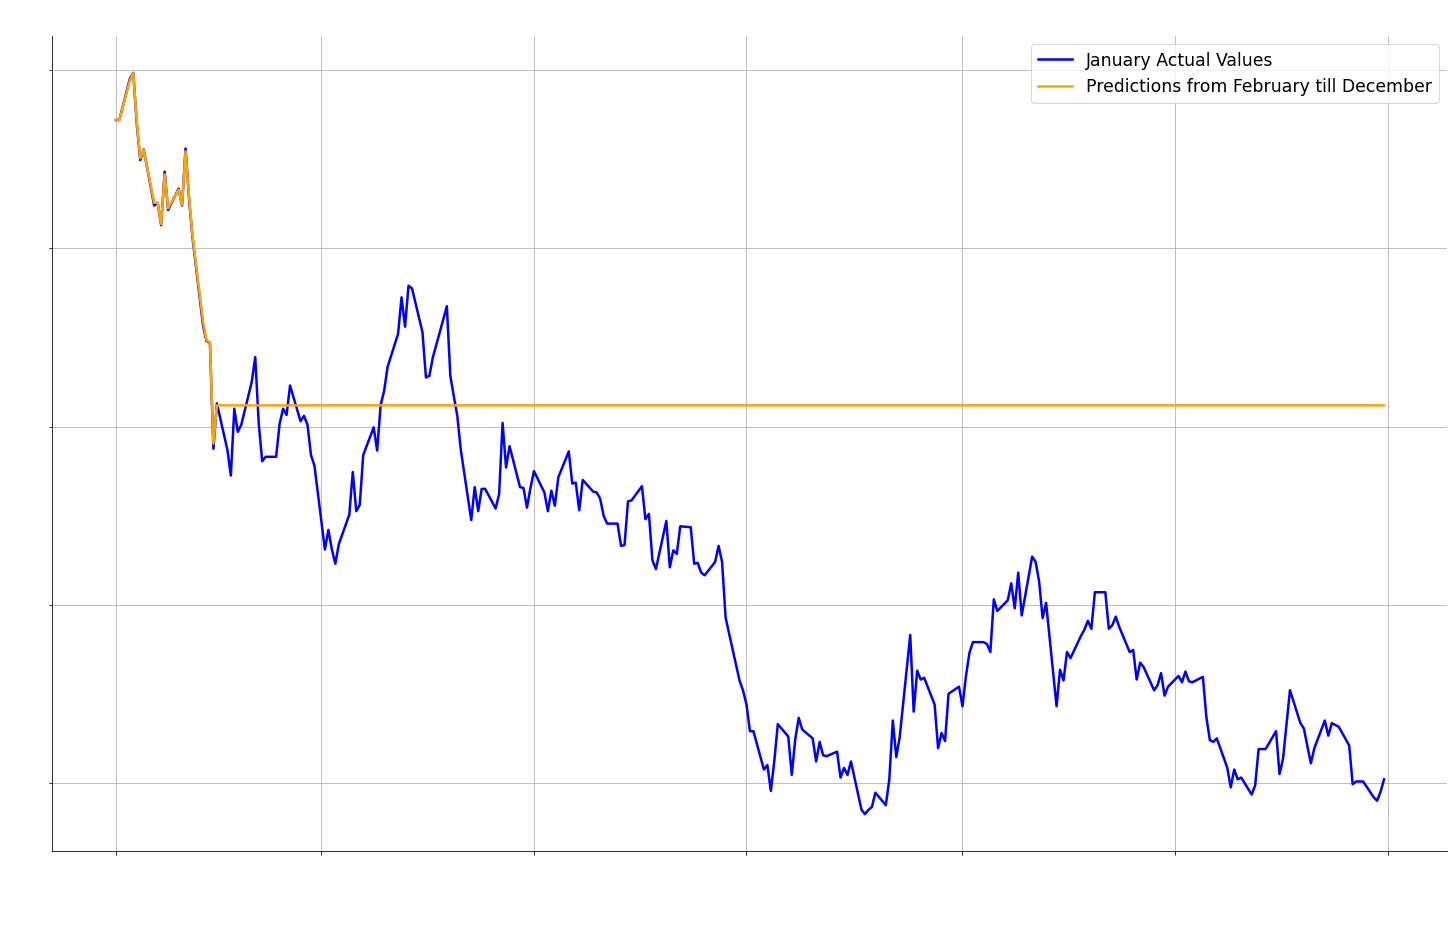

In [25]:
rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5

# Plot
plt.figure(figsize=(25,15))
plt.plot(df_1981["Price"], color = "blue",label='January Actual Values')
plt.plot(dfs[4]['Predicted_Price_0.95'], color = "orange",label='Predictions from February till December')

plt.title('Stocks dataset', size=30, color="w")
plt.grid()
plt.xticks(color="w", size=20, rotation=45)
plt.yticks(color="w", size=20)
plt.legend(fontsize='xx-large')
plt.show()